In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pandas.errors import ParserWarning

warnings.simplefilter(action='ignore', category=ParserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import utils.data as datutils

In [3]:
mah_df_list = []
dir = 'data/gadgetx3k_20/AHF_History/'
for f in os.listdir(dir):
    file = dir + f
    mm0 = datutils.load_mah(file)
    mah_df_list.append(mm0)

In [4]:
dsdf = pd.read_csv(
    'data/gadgetx3k_20/G3X_progenitors/DS_G3X_snap_128_center-cluster_progenitors.txt',
    sep=r'\s+', header=0)

int_columns = [0, 1, 2, 7]
column_names = dsdf.columns

for idx in range(len(column_names)):
    col_name = column_names[idx]
    if idx in int_columns:
        dsdf[col_name] = dsdf[col_name].astype(int)
    else:
        dsdf[col_name] = dsdf[col_name].astype(float)
dsdf.drop(columns=['rID[0]', 'Hid[1]', 'DS_200[2]', 'DS_500[7]'], inplace=True)
dsdf = dsdf [:20]

In [ ]:
corrs_list = []
z_list = []
mah_ds_dict = {}
for z in mah_df_list[0]['Redshift']:
    mah_df = pd.DataFrame(columns=['M/M0'])

    for region in range(20):
        row = mah_df_list[region].loc[mah_df_list[region]
                                      ['Redshift'] == z, ['M/M0']]
        if not row.empty:
            mah_df = pd.concat([mah_df, row], ignore_index=True)

    if mah_df.shape[0] != dsdf.shape[0]:
        print(
            f"Skipping redshift {z}: mismatched rows {mah_df.shape[0]} vs {dsdf[:20].shape[0]}")
        continue

    df = pd.concat([mah_df.reset_index(drop=True),
                   dsdf[:20].reset_index(drop=True)], axis=1)
    mah_ds_dict[z] = df
    corrs = df.corr(method='spearman')
    corrs_list.append(corrs)
    z_list.append(z)

z_array = np.array(z_list)
aexp = 1/(1+z_array)

Skipping redshift 0.021: mismatched rows 19 vs 20
Skipping redshift 0.044: mismatched rows 19 vs 20
Skipping redshift 0.167: mismatched rows 19 vs 20
Skipping redshift 0.193: mismatched rows 18 vs 20
Skipping redshift 0.22: mismatched rows 18 vs 20
Skipping redshift 0.247: mismatched rows 19 vs 20
Skipping redshift 0.858: mismatched rows 19 vs 20
Skipping redshift 1.269: mismatched rows 19 vs 20
Skipping redshift 1.369: mismatched rows 3 vs 20
Skipping redshift 1.477: mismatched rows 5 vs 20
Skipping redshift 1.589: mismatched rows 7 vs 20
Skipping redshift 1.644: mismatched rows 7 vs 20
Skipping redshift 1.765: mismatched rows 12 vs 20
Skipping redshift 1.89: mismatched rows 14 vs 20
Skipping redshift 2.021: mismatched rows 18 vs 20
Skipping redshift 2.159: mismatched rows 19 vs 20
Skipping redshift 3.3: mismatched rows 1 vs 20
Skipping redshift 3.591: mismatched rows 5 vs 20
Skipping redshift 3.7: mismatched rows 5 vs 20
Skipping redshift 4.018: mismatched rows 10 vs 20
Skipping reds

In [21]:
aexp[aexp != 1]

1      0.979432
2      0.957854
3      0.936330
4      0.915751
5      0.896057
         ...   
104    0.100231
105    0.098377
106    0.095657
107    0.093888
108    0.092140
Name: aexp, Length: 108, dtype: float64

In [41]:
n_snaps = [len(df) for df in mah_df_list]
most_snaps_indx = np.argmax(n_snaps)

mah_ds_dict = {}
aexp = mah_df_list[most_snaps_indx]['aexp']
for a in aexp:
    # setup df for all MM0 values at this snap
    mah_df = pd.DataFrame(columns=['M/M0'])
    bad_regions = []  # indices for regions without MM0 at this snap
    for region in range(20):
        row = mah_df_list[region].loc[mah_df_list[region]
                                   ['aexp'] == a, ['M/M0']]

        if not row.empty:   # then there is an MM0 value for this region at snap
            mah_df = pd.concat([mah_df, row], ignore_index=True)
        else:
            bad_regions.append(region)

    if len(bad_regions) != 0:
        ds = dsdf.drop(bad_regions, axis=0)
    else:
        ds = dsdf

    if len(ds) < 18:    # dont want too few entries for correlation calculation
        aexp = aexp[aexp != a]
        continue
    
    df = pd.concat([mah_df.reset_index(drop=True),
                   ds.reset_index(drop=True)], axis=1)
    mah_ds_dict[a] = df

corrs_list = [df.corr(method='spearman') for df in mah_ds_dict.values()]

In [42]:
eta_200 = [df.loc['eta_200[3]', 'M/M0'] for df in corrs_list]
delta_200 = [df.loc['delta_200[4]', 'M/M0'] for df in corrs_list]
fm_200 = [df.loc['fm_200[5]', 'M/M0'] for df in corrs_list]
fm2_200 = [df.loc['fm2_200[6]', 'M/M0'] for df in corrs_list]
eta_500 = [df.loc['eta_500[8]', 'M/M0'] for df in corrs_list]
delta_500 = [df.loc['delta_500[9]', 'M/M0'] for df in corrs_list]
fm_500 = [df.loc['fm_500[10]', 'M/M0'] for df in corrs_list]
fm2_500 = [df.loc['fm2_500[11]', 'M/M0'] for df in corrs_list]

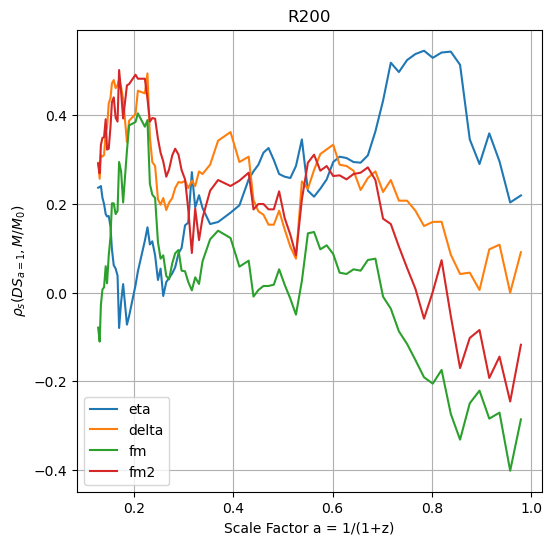

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('R200')
axs.plot(aexp, eta_200, label='eta')
axs.plot(aexp, delta_200, label='delta')
axs.plot(aexp, fm_200, label='fm')
axs.plot(aexp, fm2_200, label='fm2')
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, M/M_0)$')
axs.grid()
plt.legend()
plt.show()

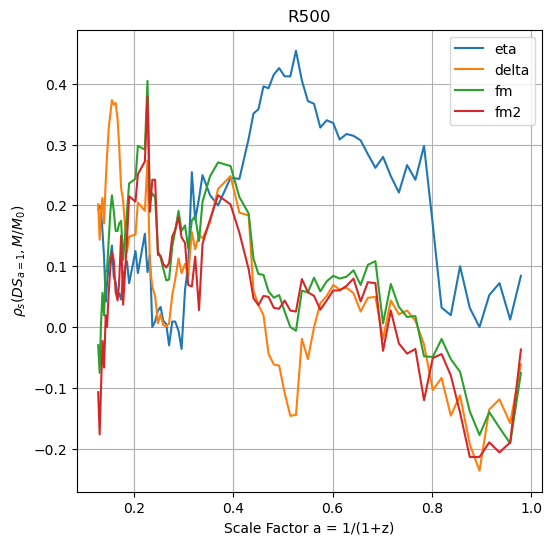

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('R500')
axs.plot(aexp, eta_500, label='eta')
axs.plot(aexp, delta_500, label='delta')
axs.plot(aexp, fm_500, label='fm')
axs.plot(aexp, fm2_500, label='fm2')
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, M/M_0)$')
axs.grid()
plt.legend()
plt.show()

In [ ]:
fm2_200_p10 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=10)
fm2_200_p25 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=25)
fm2_200_p50 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=50)
fm2_200_p75 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=75)
fm2_200_p90 = datutils.get_perc(mah_ds_dict, param='fm2_200[6]', q=90)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
axs.set_title('fm2_200')
axs.plot(aexp, fm2_200_p50, color='b')
axs.fill_between(aexp, fm2_200_p10, fm2_200_p90, color='b', alpha=0.2)
axs.fill_between(aexp, fm2_200_p25, fm2_200_p75, color='b', alpha=0.3)
axs.set_xlabel('Scale Factor a = 1/(1+z)')
axs.set_ylabel(r'$\rho_s (DS_{a=1}, M/M_0)$')
axs.grid()
plt.show()

### Now for aexp(M/M0)...

In [5]:
size = 100  
mm0 = np.linspace(1e-5, 1, size)      # set up mah array
mm0_dict = {}
for m in mm0:
    # create dataframe for each mm0 value
    mm0_dict[m] = pd.DataFrame(columns=['aexp'])

In [6]:
tol = 1e-2
for mah in mah_df_list:
    # For each row in each mah snap, if it is close to an mm0 value then go to
    # dataframe at corresponding mm0_dict key and add the row(s) to that df.
    # In the end, for each mm0 value there is a df of aexp values.
    for m in mm0:
        err = np.abs((mah['M/M0'] - m))
        mask = err < tol
        mm0_dict[m] = pd.concat([mm0_dict[m], mah['aexp'][mask]])

In [7]:
# now we assemble the dictionary of ds+aexp params
# each key is an mm0 val, each val is the joint df
ds_aexp_dict = {}
for k, df in mm0_dict.items():
   if len(df) > len(dsdf):
      df1 = df.sample(len(dsdf))
      df2 = dsdf
   else:
      df1 = df
      df2 = dsdf.sample(len(dsdf))
   ds_aexp_dict[k] = pd.concat([df2.reset_index(drop=True),
                                df1.reset_index(drop=True)], axis=1)

In [ ]:
ds_aexp_corrs = {}
for k, v in ds_aexp_dict.items():
    ds_aexp_corrs[k] = v.corr(method='spearman')

In [ ]:
eta_200 = [df.loc['eta_200[3]', 'aexp'] for _, df in ds_aexp_corrs.items()]
delta_200 = [df.loc['delta_200[4]', 'aexp'] for _, df in ds_aexp_corrs.items()]
fm_200 = [df.loc['fm_200[5]', 'aexp'] for _, df in ds_aexp_corrs.items()]
fm2_200 = [df.loc['fm2_200[6]', 'aexp'] for _, df in ds_aexp_corrs.items()]
eta_500 = [df.loc['eta_500[8]', 'aexp'] for _, df in ds_aexp_corrs.items()]
delta_500 = [df.loc['delta_500[9]', 'aexp'] for _, df in ds_aexp_corrs.items()]
fm_500 = [df.loc['fm_500[10]', 'aexp'] for _, df in ds_aexp_corrs.items()]
fm2_500 = [df.loc['fm2_500[11]', 'aexp'] for _, df in ds_aexp_corrs.items()]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
fig.suptitle('R200')

axs[0, 0].plot(mm0, eta_200, label='eta')
axs[0, 0].grid()
axs[0, 0].legend()

axs[0, 1].plot(mm0, delta_200, label='delta')
axs[0, 1].grid()
axs[0, 1].legend()

axs[1, 0].plot(mm0, fm_200, label='fm')
axs[1, 0].grid()
axs[1, 0].legend()

axs[1, 1].plot(mm0, fm2_200, label='fm2')
axs[1, 1].grid()
axs[1, 1].legend()

axs[1, 0].set_xlabel('M/M0')
axs[1, 1].set_xlabel('M/M0')
axs[0, 0].set_ylabel(r'$\rho_s (DS_{a=1},aexp)$')
axs[1, 0].set_ylabel(r'$\rho_s (DS_{a=1},aexp)$')

plt.tight_layout()
plt.legend()
plt.show()